In [15]:
#Studnet: Jhuma kabir meem
#Exercise Cuda shared meory


In [16]:
# -- initialize the device
# !pip install pycuda
import numpy as np
import pycuda.driver as cuda
import pycuda.autoinit
import pycuda.gpuarray as gpuarray
import numpy as np
from pycuda import driver, compiler, gpuarray, tools
import pycuda.autoinit

In [3]:
# Part 1 Generate two random matrices and implement CUDA kernel performing matrix multiplication
start = cuda.Event()
end   = cuda.Event()

# kernel code for matrix multiplication

kernel_matrix_multiplication_code = """
__global__ void MatrixMulKernel(float *a, float *b, float *c)
{
    int tx = threadIdx.x;
    int ty = threadIdx.y;
    float P_value = 0;

    for (int k = 0; k < %(m_size)s; ++k) {
        float a_e = a[ty * %(m_size)s + k];
        float b_e = b[k * %(m_size)s + tx];
        P_value += a_e * b_e;
    }
    c[ty * %(m_size)s + tx] = P_value;
}
"""


m_size = 10 # define matrix size

A = np.random.randn(m_size, m_size).astype(np.float32) # create two random square matrices
B = np.random.randn(m_size, m_size).astype(np.float32)

multiplication_cpu = np.dot(A, B) # compute cpu matrix multiplication to compare  GPU computation


a_gpu = gpuarray.to_gpu(A) # transfer host (CPU) memory to device (GPU) memory 
b_gpu = gpuarray.to_gpu(B)

# create empty gpu array 
multiplication_gpu = gpuarray.empty((m_size, m_size), np.float32)

start.record()
# get the kernel code  and  by specifying matrix size
kernel_code = kernel_matrix_multiplication_code % {
    'm_size': m_size 
    }

# compile the kernel code 
mod = compiler.SourceModule(kernel_code)

# get the kernel function from the compiled module
matrixmul = mod.get_function("MatrixMulKernel")

# call the kernel on the card
matrixmul( a_gpu, b_gpu, multiplication_gpu, block = (m_size, m_size, 1),
    )

end.record() 
end.synchronize()
secs = start.time_till(end) * 1e-3


#print the results
print("-" * 10)
print ("Random Matrix A:")
print (a_gpu.get())

print ("-" * 10)
print ("Random Matrix B:")
print (b_gpu.get())

print ("-" * 10)
print ("Matrix multiplication of A and B (GPU):")
print (multiplication_gpu.get())

print("Processing time = %fs" % (secs))



----------
Random Matrix A:
[[ 0.93866765 -2.6416337  -0.95828307 -0.6338624   1.2799077   1.2473533
  -0.5818693  -0.78458554  0.00267178 -0.20464058]
 [-0.44912857 -2.210556   -0.4995095   0.12703684  0.594778   -0.9700369
   0.9201594   0.50839704  0.81264603 -1.2299548 ]
 [ 0.97856927 -0.04062505  0.6629906  -1.7069463   1.6345431   0.47249028
   1.5713474  -2.0081544   0.10232198  1.6451004 ]
 [-1.6066277  -0.6750371   1.2075     -0.6626851   2.3422635   1.4289261
  -1.5248857  -0.29694444  0.74334806  1.3660611 ]
 [ 2.1130786   1.7713369  -0.9662753   0.36454675 -0.33692187 -1.0940413
  -2.2118208   0.27129877  0.845564    0.6237441 ]
 [-0.09238169  1.1246402   1.0999067  -0.48253673  0.60070574 -0.82444894
  -0.14850119 -0.7215916  -1.70408    -0.7266248 ]
 [ 0.09615792 -1.5756468  -1.0936466   0.6306676  -0.09044864 -0.88330597
  -0.5548907  -0.53818566  0.11348673 -0.04990162]
 [-1.6102431   0.07088288 -0.75328547 -0.84387094  0.1340139   0.22829737
  -0.00585976 -0.47806218  

In [4]:
#Part 1 Generate two random matrices and implement CUDA kernel performing matrix multiplication with shared memory
start = cuda.Event()
end   = cuda.Event()

# kernel code for matrix multiplication

kernel_matrix_multiplication_code = """
__global__ void MatrixMulKernel(float *a, float *b, float *c)
{
    __shared__ double sub_A[%(m_size)s][%(m_size)s];
    __shared__ double sub_B[%(m_size)s][%(m_size)s];

    int row = blockIdx.y * %(m_size)s + threadIdx.y;
    int col = blockIdx.x * %(m_size)s + threadIdx.x;
    int tx = threadIdx.x;
    int ty = threadIdx.y;
    int bx = blockIdx.x;
    int by = blockIdx.y;
    double result = 0.0;


    for (int k = 0; k < (%(m_size)s + %(m_size)s - 1) / %(m_size)s; k++)
    {
    sub_A[ty][tx] = a[row * %(m_size)s + 0 * %(m_size)s + tx];
    sub_B[ty][tx] = b[(k * %(m_size)s + ty) * %(m_size)s + col];

    for (int i = 0; i < %(m_size)s; i++)
    result += sub_A[ty][i] * sub_B[i][tx];
    __syncthreads();
  
    }

    int C_index = (by * blockDim.y + ty) * %(m_size)s + (bx * blockDim.x + tx);
    
    c[C_index] = result;

}
"""


# create empty gpu array 
C = gpuarray.empty((m_size, m_size), np.float32)

start.record()

# get the kernel code  and  by specifying matrix size
kernel_code = kernel_matrix_multiplication_code % {
    'm_size': m_size 
    }

# compile the kernel code 
mod = compiler.SourceModule(kernel_code)

# get the kernel function from the compiled module
matrixmul = mod.get_function("MatrixMulKernel")

# call the kernel on the card
matrixmul( a_gpu, b_gpu, C, block = (m_size, m_size, 1),
    )

end.record() 
end.synchronize()
secs = start.time_till(end) * 1e-3

print ("-" * 10)
print ("Matrix multiplication with shared memory of A and B (GPU):")
print (C.get())

print("Processing time = %fs" % (secs))



----------
Matrix multiplication with shared memory of A and B (GPU):
[[  4.2859955    4.8207917   -3.6201746   -0.0279277    1.355096
   -1.2757765   -3.9870296   -5.448379    -6.8861785   -1.3417199 ]
 [  0.17287435   4.438613    -2.7915173   -9.304696     0.93144166
    1.6922256   -1.328741     0.10675113  -1.9407884   -3.7632244 ]
 [ -2.4457345    4.7989087   -7.3788195    3.3087635    6.5759277
   -1.5620999   -1.1632267   -5.464736    -3.482198     1.8677765 ]
 [  1.9717467    4.8814926   -4.052733     6.605256     0.26543045
   -0.5564401  -10.601746    -4.0708227   -6.0016737    5.1125665 ]
 [  2.8553436    1.7434409   -1.6777221    5.055967    -2.4322212
    1.86765      2.9895108    1.3670449    3.9581196    3.4323654 ]
 [ -0.97120875  -1.6385239   -1.3966482    1.7495545   -2.1451473
    0.7613729    1.6651299    1.9806957   -0.29034358   1.210861  ]
 [  0.2930743    3.6179783   -2.390031    -4.174668     1.7037567
    2.4068387   -3.7036214   -3.5536408   -1.3685855   -1.4

In [14]:
print('Result shows that matrix GPU multplication takes Processing time = 0.013488s, Otherhand Matrix multiplication with shared memory take less  Processing time which is = 0.004646s')

Result shows that matrix GPU multplication takes Processing time = 0.013488s, Otherhand Matrix multiplication with shared memory take less  Processing time which is = 0.004646s


Processing time = 0.000211s
Processing time with using shared memory= 0.000194s


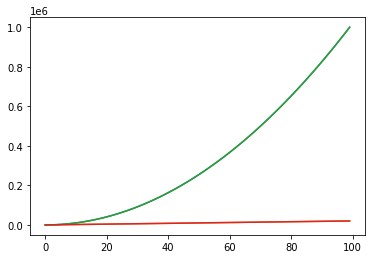

In [12]:
# Part 2 (Implement vector differentiation similar to matlab diff function)

import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import matplotlib.pyplot as plt

start = cuda.Event()
end   = cuda.Event()


size=100
A = np.linspace(0, 1000, size, endpoint=True)**2

A = A.astype(np.float32)

a = gpuarray.to_gpu(A)

diff = gpuarray.empty_like(a)


mod = SourceModule("""

    __global__ void diff_function(float *a, float *diff)
    {
      int tx = threadIdx.x;
      float a_e;
      for (int k = 0; k <1000; ++k) {

      if ((k==0))
      {
          a_e = a[tx+1];

          diff[tx] = a_e;
      }
      else{
          a_e = a[tx]-a[tx-1];
          diff[tx] = a_e;
      } 

      }   

    }
    """)


start.record()

func = mod.get_function("diff_function")
func(a,diff, block=(size,1,1))
end.record() 
end.synchronize()
secs = start.time_till(end) * 1e-3

print("Processing time = %fs" % (secs))





plt.plot( A)
plt.plot( diff.get())

# Part 2 (Implement vector differentiation similar to matlab diff function using shared memory)


mod = SourceModule("""

    __global__ void diff_function(float *a, float *diff)
    { 
      __shared__ double s_xs[1000];
      int tx = threadIdx.x;
      float a_e;
      for (int k = 0; k <1000; ++k) {

      if ((k==0))
      {
          s_xs[tx] = a[tx+1];
          diff[tx] = s_xs[tx] ;
      }
      else{
          
          s_xs[tx] = a[tx]-a[tx-1];
          diff[tx] = s_xs[tx];
      } 

      }   

    }
    """)


start.record()

func = mod.get_function("diff_function")
func(a,diff, block=(size,1,1))
end.record() 
end.synchronize()
secs = start.time_till(end) * 1e-3

print("Processing time with using shared memory= %fs" % (secs))

plt.plot( A)
plt.plot( diff.get())

In [13]:
print('Result showing uisng shared memory run time has decreased')

Result showing uisng shared memory run time has decreased
